In [7]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt

# some parameters
patch_size = 10
sigma =20
window_stride = 3
num_dict=2000
ksvd_iter = 1
max_sparsity = 2

In [8]:
def sliding_image(arr_in, patch_size, step=1):
    """
    Input
        arr_in : ndarray. N-d input array.
        patch_size : integer. sliding window size
        step : stride of sliding window
    Returns
        arr_out : All patches. (num, num, patch_size, patch_size)
    """
    # image size
    m_size, n_size = arr_in.shape
    # number of patches
    r = (m_size - patch_size) // step + 1
    c = (n_size - patch_size) // step + 1
    # all patches
    arr_out = np.zeros((r,c,patch_size,patch_size))
    for i in range(r):
        for j in range(c):
            rpos = i * step
            cpos = j * step
            # select patches
            arr_out[i,j] = arr_in[rpos:rpos+patch_size, cpos:cpos+patch_size]
    return arr_out


def getImagePatches(img, stride):
    '''
    Input：
        - img: image matrix
        - stride：stride of sliding window
    Return：
        - patches - (m,n) √m*√m-size's sliding window sampling patches.
            - m: window size vec
            - n: number of samples
        - patch - (r, c, √m, √m)
            - r: number of window patches on vertical direction
            - c: number of window patches on horizontal direction
            - √m: window size
            e.g. - (44,44, 7,7) 44*44 patches，each patch is 7*7 size
    '''
    # get indices of each patch from image matrix
    # This is also the R_{ij} marix mentioned in the paper
    patch_indices = sliding_image(img, patch_size, step=stride) # 返回 (r,c)个(window_shape)的数组(94,94,7,7)

    r,c= patch_indices.shape[0:2]  # window matrix size: r*c sliding patches
    i_r,i_c=patch_indices.shape[2:4]  # image patch size
    patches = np.zeros((i_r*i_c, r*c)) # every column is a patch
    # extract each image patchlena.png
    for i in range(r):
        for j in range(c):
            # extend patch to a vec -〉 (7*7, 44*44)
            patches[:, j+patch_indices.shape[1]*i] = np.concatenate(patch_indices[i, j], axis=0)
    return patches, patch_indices.shape


def omp(D, data, sparsity, mask):
    '''
    Given D，Y; Calculate X
    Input:
        D - dictionary (m, n-dims)
        data - Y: all patches (m, num-sample)
        sparsity - sparsity of x
        mask - M: mask matrix for all patches (m, num-sample)
    Output:
        X - sparse vec X: (n-dims, num-sample)
    '''
    X = np.zeros((D.shape[1], data.shape[1]))  # (n-dims, num-sample)
    tot_res = 0   # collect normed residual from every y-D@x
    # go through all data patches
    for i in range(data.shape[1]):
        # for all num-samples, every sample will have k-sparsity
        # every loop, finish one sample x
        ################### process bar ########################
        count = np.floor((i + 1) / float(data.shape[1]) * 100)
        sys.stdout.write("\r- omp Sparse coding : Channel : %d%%" % count)
        sys.stdout.flush()
        #######################################################
        mi = mask[:,i]==1 # (m,) of true/false
        D_temp = D[mi,:]  # select meaningful rows
        y = data[:,i]
        y_true = y[mi] # keep meaningful data
        res = y_true  # initial residual
        thresh = np.linalg.norm(res)*0.01
        omega = []
        res_norm = np.linalg.norm(res)
        xtemp_sparse = np.zeros(D.shape[1])  # (500,)

        while len(omega) < sparsity and res_norm>thresh:
            # loop until x has sparsity-sparse (k-sparsity)
            # every loop, find one more sparse element
            proj = D_temp.T @ res  # projection: find the max correlation between residual&D
            i_til = np.argmax(np.abs(proj))  # max correlation column
            omega.append(i_til)
            xtemp_sparse = np.linalg.pinv(D_temp[:,omega])@y_true   # x = D^-1 @ y
            d_omg = D_temp[:, omega]                  # (m, columns now have)
            recover_alr_y = d_omg @ xtemp_sparse  # y_til now can recover
            res = y_true - recover_alr_y           # calculate residual left
            res_norm = np.linalg.norm(res)  # update norm residual of this x
        #
        # tot_res += res_norm
        # update xi
        if len(omega) > 0:
            X[omega, i] = xtemp_sparse
    print('\r Sparse coding finished.\n')
    return X

def initiate_D(patches, dict_size):
    '''
    dictionary intialization
    assign data columns to dictionary at random
    :param patches: (m, num of samples)
    :param dict_size: n-dims - then this would be the dimension of sparse vector x
    :return:
    D: normalized dictionary D
    '''
    # random select n-dims columns index
    indices = np.random.random_integers(0, patches.shape[1] - 1, dict_size)  #
    # choose the n-dims columns in Y as initial D
    D = np.array(patches[:, indices])  # select n-dims patches

    return D - D.mean()  # return normalized dictionary

def update_D(D, data, X, j, mask):
    '''
    Input:
        D - Dictionary (m, n-dims)
        data - Y all patches (m, num of samples)
        X: sparse matrix for x。(n-dims, num of samples) 每个patch变成了500维的稀疏向量，有8836个patch。
        j: now update the jth column of D
        mask - M: mask matrix for all patches (m, num-sample)
    Output:
        D_temp: new dictionary
        X: X would be updated followed by D
    '''
    indices = np.where(X[j, :] != 0)[0]  # find all x contributed to the i_til column
    D_temp = D  # work on new dictionary
    X_temp = X[:, indices]  # all x contributed to the i_til column

    if len(indices) > 1:
        # there're x contribute to this column
        X_temp[j, :] = 0  # set X's i_til row element to 0. remove the contribute to this column
        # ek: Y - D@X_temp: the contribution only of j column.
        # mask set unmeaningful to 0
        e_k = mask[:,indices]*(data[:, indices] - D_temp @ X_temp)  # (m, a couple of columns)
        # make ek to be 2D matrix. (if only have 1 column, e_k would be a 1d array)
        u, s, vt = np.linalg.svd(np.atleast_2d(e_k))
        u = u[:,0]         # the first one
        s = s[0]            # largest one
        vt = vt[0,:]        # the first one
        D_temp[:, j] = u  # update dictionary with first column
        X[j, indices] = s * vt  # update x the sparse representations
    else:
        # no x have non-zero element corresponding to this column
        pass

    return D_temp, X

def k_svd(patches, dict_size, sparsity, mask):
    '''
    :param patches: patches from image (m, num of samples)
    :param dict_size: n-dims of every x
    :param sparsity: sparsity of every x
    mask - M: mask matrix for all patches (m, num-sample)
    :return:
        D: final dictionary
        X: corresponding X matrix (perhaps not sparse, so need omp to update again)
    '''
    # initial dictionary D
    D = initiate_D(patches, dict_size)
    # initializing sparse matrix: X
    X = np.zeros((D.T.dot(patches)).shape)  # (n-dims, num of samples)

    for k in range(ksvd_iter):  # ksvd_iter = 1
        print("KSVD Iter: {}/{} ".format(k + 1, ksvd_iter))
        # E step， update X
        X = omp(D, patches, sparsity, mask)  # (n-dims, num of samples)
        # M step，update D
        count = 1
        dict_elem_order = np.random.permutation(D.shape[1])  # (0 ~ n-dims-1) array
        # get order of column elements
        for j in dict_elem_order:
            # update D column by column
            ################## process bar ###############################
            r = np.floor(count / float(D.shape[1]) * 100)
            sys.stdout.write("\r- k_svd Dictionary updating : %d%%" % r)
            sys.stdout.flush()
            ##############################################################
            # calculate the jth column
            D, X = update_D(D, patches, X, j, mask)
            count += 1
        print("\nDictionary updating  finished")
    return D, X

def inpainting(img_degrade, dict_size, sparsity, mask):
    '''
    Input:
        img_noisy: input image
        dict_size: n-dims
        sparsity: sparsity of x
        mask - M: mask matrix for all patches (m, num-sample)
    Return:
        denoised_image: denoised image
    '''
    # generate noisy patches.
    s=window_stride
    # get patches
    patches, patches_shape = getImagePatches(img_degrade, s)
    mean = patches.mean()
    patches = patches - mean

    # K-SVD.
    dict_final, sparse_init = k_svd(patches, dict_size, sparsity,mask)

    # omp
    degrade_patches, degrade_patches_shape = getImagePatches(img_degrade, s)
    data_mean = degrade_patches.mean()
    degrade_patches = degrade_patches - data_mean

    sparse_final = omp(dict_final, degrade_patches, sparsity, mask)

    # Reconstruct the image.
    patches_approx = np.dot(dict_final, sparse_final) + data_mean
    inpainting_image = reconstruct_image(patches_approx, img_degrade, s)

    return inpainting_image

def reconstruct_image(patch_final, degraded_image, stride):
    '''
    :param patch_final: recovered patches i.g. (m, num)
    :param degraded_image: image of degraded
    :param stride: stride when select patches
    :return:
        img_out: denoised image
    '''
    # image size
    m_size,n_size = degraded_image.shape
    # number of patches
    r = (m_size-patch_size)//stride+1
    c = (n_size-patch_size)//stride+1
    # output image
    img_out = np.zeros((m_size,n_size))
    # weight matrix
    weight = np.zeros((m_size,n_size))
    for i in range(r):
        for j in range(c):
            rpos = i*stride
            cpos = j*stride
            img_out[rpos:rpos+patch_size,cpos:cpos+patch_size] += patch_final[:,i*c+j].reshape(patch_size,patch_size)
            weight[rpos:rpos+patch_size,cpos:cpos+patch_size] += 1
    # average image patches
    img_out = img_out/weight
    return img_out.astype(np.float64)

In [9]:
def main():
    # read degraded iamge (grayscale )
    s=window_stride
    orimg = cv2.imread("barbaraorig.png", 0)
    image = cv2.imread("barbaramasked.png", 0)
    orimg = cv2.resize(orimg,(256,256))
    image = cv2.resize(image,(256,256))

    r,c = image.shape
    mask = np.ones((r,c))
    mask[image!=orimg] = 0
    mask,_ = getImagePatches(mask,s)

    print('num_dict:',num_dict,'max_sparsity:',max_sparsity)
    # denose the given image
    inpainting_image = inpainting(image, dict_size=num_dict, sparsity=max_sparsity, mask=mask)

    # save images
    # cv2.imwrite("lena.png".split(".")[0]+str(sigma)+"noisy.jpg", noisy_image.astype('uint8'))
    cv2.imwrite("barbaramasked.png".split(".")[0]+"inpainting.png", inpainting_image.astype('uint8'))
    # cv2.imwrite("lena.png".split(".")[0]+str(sigma)+"difference.jpg", np.abs(noisy_image - denoised_image).astype('uint8'))

    #     print("PSRN: {}(noisy), {}(denoised))".format(noisy_psnr, final_psnr))
    return 0

if __name__=='__main__':
    main()

num_dict: 2000 max_sparsity: 2
KSVD Iter: 1/1 
- omp Sparse coding : Channel : 1%

/Users/handsomeb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: DeprecationWarning: This function is deprecated. Please call randint(0, 6888 + 1) instead


 Sparse coding finished.annel : 100%

- k_svd Dictionary updating : 100%
Dictionary updating  finished
 Sparse coding finished.annel : 100%



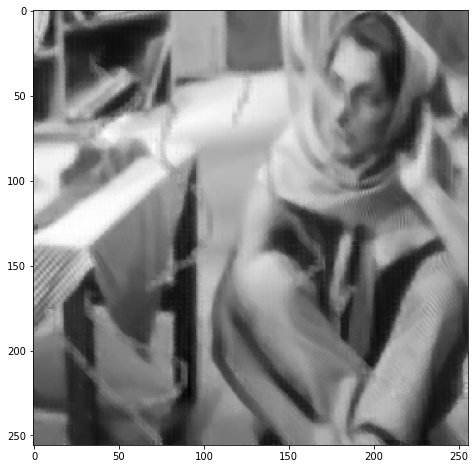

In [11]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
a = cv2.imread("barbaramaskedinpainting.png", 0)
plt.imshow(a,"gray")

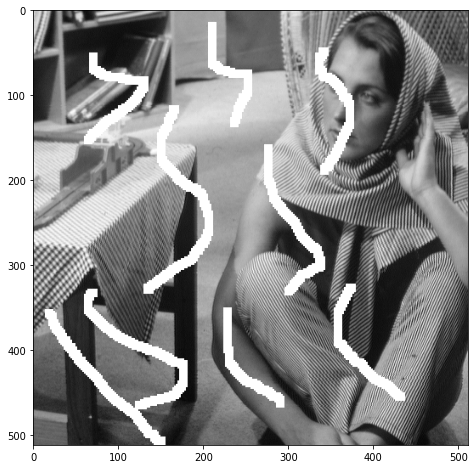

In [12]:
b = cv2.imread("barbaramasked.png", 0)
plt.imshow(b,"gray")

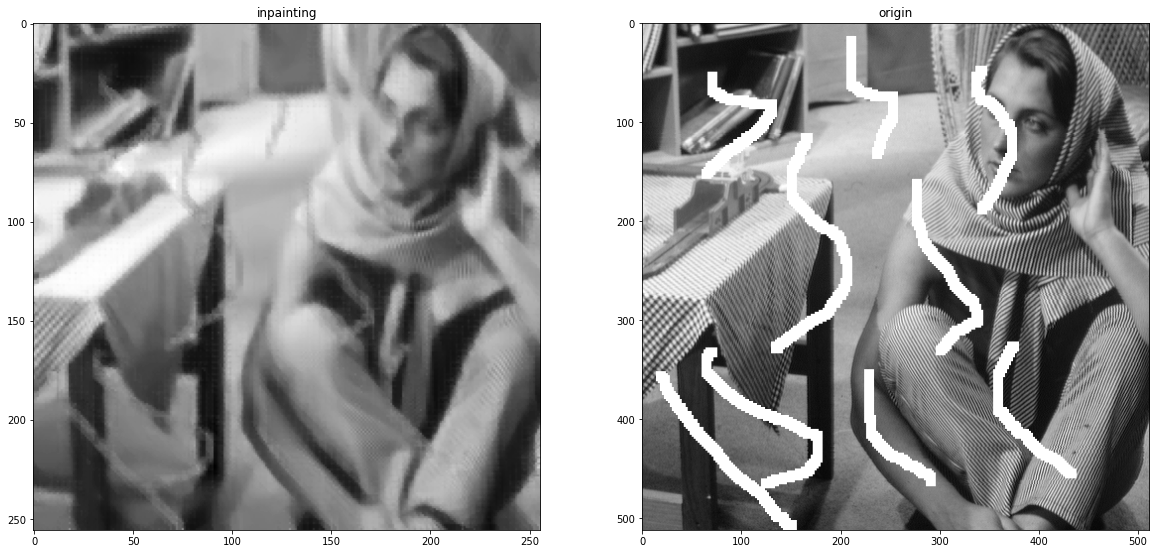

In [13]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.subplot(1,2,1)
plt.title("inpainting")
plt.imshow(a,"gray")
plt.subplot(1,2,2)
plt.title("origin")
plt.imshow(b,"gray")
plt.show()